# Processing Flow


## Install necessary modules


In [41]:
%pip install uv
!uv pip install duckdb jupysql ipykernel sqlalchemy duckdb-engine pandas 


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Using Python 3.11.4 environment at: /Users/nivanrs/miniconda3
Audited 6 packages in 49ms


## Import Modules and Initiate DuckDB


In [107]:
import duckdb
from sqlalchemy import create_engine
import pandas as pd

%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False

# Create DuckDB connection (saving)
%sql duckdb:///dev.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## List Table


In [43]:
%sqlcmd tables

Name
dim_datetime
dim_tokens
dim_users
dm_token_daily_summary
dm_user_daily_trading
dm_user_token_flows
dq_trade_duplicates
dq_trade_outliers
dq_transfer_outliers
fact_trades


## data evaluation and data loading


### transfers


In [44]:
transfers = pd.read_csv("../../data/raw_p2p_transfers.csv")
transfers

,transfer_id,sender_id,receiver_id,token_id,amount,status,transfer_created_time,transfer_updated_time
0,P2P0001,U017,U005,SOL,136.340602,SUCCESS,2024-01-08 15:56:56,2024-01-08 15:56:56
1,P2P0002,U023,U008,USDT,2124.162930,SUCCESS,2024-01-28 5:52:29,2024-01-28 5:52:29
2,P2P0003,U014,U033,USDT,1315.962732,SUCCESS,2024-01-05 9:06:10,2024-01-05 9:06:10
3,P2P0004,U035,U001,USDT,1129.177555,SUCCESS,2024-01-29 15:33:26,2024-01-29 15:33:26
4,P2P0005,U032,U010,XRP,122.677632,SUCCESS,2024-01-06 16:29:03,2024-01-06 16:29:03
...,...,...,...,...,...,...,...,...
175,P2P0176,U010,U045,XRP,99.656284,SUCCESS,2024-06-11 23:01:38,2024-06-11 23:01:38
176,P2P0177,U007,U014,BTC,0.260988,FAILED,2024-06-05 1:45:39,2024-06-05 1:48:39
177,P2P0178,U005,U016,ETH,0.310714,FAILED,2024-06-15 14:28:24,2024-06-15 14:36:24
178,P2P0179,U006,U038,DOGE,29.513625,SUCCESS,2024-06-25 2:20:51,2024-06-25 2:20:51


consist of 8 cols, primary key on transfer_id, no missing but the time is stil not in date format


In [45]:
transfers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   transfer_id            180 non-null    object 
 1   sender_id              180 non-null    object 
 2   receiver_id            180 non-null    object 
 3   token_id               180 non-null    object 
 4   amount                 180 non-null    float64
 5   status                 180 non-null    object 
 6   transfer_created_time  180 non-null    object 
 7   transfer_updated_time  180 non-null    object 
dtypes: float64(1), object(7)
memory usage: 11.4+ KB


#### Data loading


In [46]:
%%sql
DROP TABLE IF EXISTS stg_transfers;
CREATE TABLE IF NOT EXISTS stg_transfers (
    transfer_id TEXT,
    sender_id TEXT,
    receiver_id TEXT,
    token_id TEXT,
    amount DOUBLE,
    status TEXT,
    transfer_created_time TIMESTAMP,
    transfer_updated_time TIMESTAMP
);

INSERT INTO stg_transfers
SELECT * FROM read_csv_auto('../../data/raw_p2p_transfers.csv');


,Count
0,180


In [47]:
%%sql
SELECT * FROM stg_transfers;


,transfer_id,sender_id,receiver_id,token_id,amount,status,transfer_created_time,transfer_updated_time
0,P2P0001,U017,U005,SOL,136.340602,SUCCESS,2024-01-08 15:56:56,2024-01-08 15:56:56
1,P2P0002,U023,U008,USDT,2124.162930,SUCCESS,2024-01-28 05:52:29,2024-01-28 05:52:29
2,P2P0003,U014,U033,USDT,1315.962732,SUCCESS,2024-01-05 09:06:10,2024-01-05 09:06:10
3,P2P0004,U035,U001,USDT,1129.177555,SUCCESS,2024-01-29 15:33:26,2024-01-29 15:33:26
4,P2P0005,U032,U010,XRP,122.677632,SUCCESS,2024-01-06 16:29:03,2024-01-06 16:29:03
...,...,...,...,...,...,...,...,...
175,P2P0176,U010,U045,XRP,99.656284,SUCCESS,2024-06-11 23:01:38,2024-06-11 23:01:38
176,P2P0177,U007,U014,BTC,0.260988,FAILED,2024-06-05 01:45:39,2024-06-05 01:48:39
177,P2P0178,U005,U016,ETH,0.310714,FAILED,2024-06-15 14:28:24,2024-06-15 14:36:24
178,P2P0179,U006,U038,DOGE,29.513625,SUCCESS,2024-06-25 02:20:51,2024-06-25 02:20:51


### Tokens


In [48]:
tokens = pd.read_csv("../../data/raw_tokens.csv")
tokens

,token_id,token_name,category
0,ADA,Cardano,Layer-1
1,BNB,BNB,Layer-1
2,BTC,Bitcoin,Layer-1
3,DOGE,Dogecoin,Meme Coin
4,ETH,Ethereum,Layer-1
5,PEPE,Pepe,Meme Coin
6,SHIB,Shiba Inu,Meme Coin
7,SOL,Solana,Layer-1
8,USDT,Tether,Stablecoin
9,XRP,XRP,Layer-1


In [49]:
tokens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   token_id    10 non-null     object
 1   token_name  10 non-null     object
 2   category    10 non-null     object
dtypes: object(3)
memory usage: 372.0+ bytes


#### Tokens data loading


In [50]:
%%sql
drop table if exists stg_tokens;
CREATE TABLE IF NOT EXISTS stg_tokens (
    token_id TEXT,
    token_name TEXT,
    category TEXT
);

INSERT INTO stg_tokens
SELECT * FROM read_csv_auto('../../data/raw_tokens.csv');


,Count
0,10


In [51]:
%%sql
SELECT * FROM stg_tokens;

,token_id,token_name,category
0,ADA,Cardano,Layer-1
1,BNB,BNB,Layer-1
2,BTC,Bitcoin,Layer-1
3,DOGE,Dogecoin,Meme Coin
4,ETH,Ethereum,Layer-1
5,PEPE,Pepe,Meme Coin
6,SHIB,Shiba Inu,Meme Coin
7,SOL,Solana,Layer-1
8,USDT,Tether,Stablecoin
9,XRP,XRP,Layer-1


### Trades


In [52]:
trades = pd.read_csv("../../data/raw_trades.csv")
trades

,trade_id,user_id,token_id,side,price_usd,quantity,status,trade_created_time,trade_updated_time
0,TR0297,U050,PEPE,SELL,0.000008,4.298629e+06,FILLED,2024-06-06 4:41:51,2024-06-06 4:41:51
1,TR0150,U008,XRP,BUY,0.573315,9.573114e+06,FILLED,2024-03-04 23:43:35,2024-03-04 23:43:35
2,TR0044,U048,ETH,SELL,3959.737804,4.387170e-02,FILLED,2024-01-04 12:17:43,2024-01-04 12:17:43
3,TR0234,U031,PEPE,SELL,0.000005,2.666318e+06,FILLED,2024-04-01 21:46:15,2024-04-01 21:46:15
4,TR0199,U023,XRP,SELL,0.642871,9.557742e+06,FILLED,2024-04-22 8:58:09,2024-04-22 8:58:09
...,...,...,...,...,...,...,...,...,...
298,TR0218,U015,SOL,BUY,170.890671,1.071587e+01,FILLED,2024-04-28 3:49:45,2024-04-28 3:49:45
299,TR0133,U006,BNB,SELL,593.594773,2.639536e+01,FILLED,2024-02-09 4:11:05,2024-02-09 4:11:05
300,TR0104,U037,XRP,BUY,0.540747,3.364109e+06,FILLED,2024-02-25 14:59:45,2024-02-25 14:59:45
301,TR0259,U032,PEPE,BUY,0.000014,3.493596e+08,FILLED,2024-05-13 7:48:39,2024-05-13 7:48:39


In [53]:
trades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   trade_id            303 non-null    object 
 1   user_id             303 non-null    object 
 2   token_id            303 non-null    object 
 3   side                303 non-null    object 
 4   price_usd           303 non-null    float64
 5   quantity            303 non-null    float64
 6   status              303 non-null    object 
 7   trade_created_time  303 non-null    object 
 8   trade_updated_time  303 non-null    object 
dtypes: float64(2), object(7)
memory usage: 21.4+ KB


In [54]:
trades["trade_id"].value_counts()[lambda x: x > 1]

trade_id
TR0182    2
TR0072    2
TR0239    2
Name: count, dtype: int64

In [55]:
trades_deduped = trades.drop_duplicates(subset=["trade_id"])
trades_deduped

,trade_id,user_id,token_id,side,price_usd,quantity,status,trade_created_time,trade_updated_time
0,TR0297,U050,PEPE,SELL,0.000008,4.298629e+06,FILLED,2024-06-06 4:41:51,2024-06-06 4:41:51
1,TR0150,U008,XRP,BUY,0.573315,9.573114e+06,FILLED,2024-03-04 23:43:35,2024-03-04 23:43:35
2,TR0044,U048,ETH,SELL,3959.737804,4.387170e-02,FILLED,2024-01-04 12:17:43,2024-01-04 12:17:43
3,TR0234,U031,PEPE,SELL,0.000005,2.666318e+06,FILLED,2024-04-01 21:46:15,2024-04-01 21:46:15
4,TR0199,U023,XRP,SELL,0.642871,9.557742e+06,FILLED,2024-04-22 8:58:09,2024-04-22 8:58:09
...,...,...,...,...,...,...,...,...,...
298,TR0218,U015,SOL,BUY,170.890671,1.071587e+01,FILLED,2024-04-28 3:49:45,2024-04-28 3:49:45
299,TR0133,U006,BNB,SELL,593.594773,2.639536e+01,FILLED,2024-02-09 4:11:05,2024-02-09 4:11:05
300,TR0104,U037,XRP,BUY,0.540747,3.364109e+06,FILLED,2024-02-25 14:59:45,2024-02-25 14:59:45
301,TR0259,U032,PEPE,BUY,0.000014,3.493596e+08,FILLED,2024-05-13 7:48:39,2024-05-13 7:48:39


In [56]:
%%sql
DROP TABLE IF EXISTS stg_trades;
CREATE TABLE IF NOT EXISTS stg_trades (
    trade_id TEXT PRIMARY KEY,
    user_id TEXT,
    token_id TEXT,
    side TEXT,
    price_usd DOUBLE,
    quantity DOUBLE,
    status TEXT,
    trade_created_time TIMESTAMP,
    trade_updated_time TIMESTAMP
);

,Count


In [57]:
%%sql
INSERT INTO stg_trades
SELECT trade_id,
       user_id,
       token_id,
       side,
       price_usd,
       quantity,
       status,
       trade_created_time,
       trade_updated_time
FROM (
  SELECT *,
         ROW_NUMBER() OVER (PARTITION BY trade_id ORDER BY trade_updated_time DESC) AS rn
  FROM read_csv_auto('../../data/raw_trades.csv')
)
WHERE rn = 1;


,Count
0,300


### Users


In [58]:
users = pd.read_csv("../../data/raw_users.csv")
users

,user_id,region,signup_date
0,U001,Jakarta,2023-05-10
1,U002,Medan,2023-08-09
2,U003,Medan,2023-04-17
3,U004,Surabaya,2023-04-15
4,U005,Makassar,2023-09-20
5,U006,Bandung,2023-04-17
6,U007,Yogyakarta,2023-03-23
7,U008,Medan,2023-09-20
8,U009,Makassar,2023-08-15
9,U010,Yogyakarta,2023-03-13


In [59]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      50 non-null     object
 1   region       50 non-null     object
 2   signup_date  50 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB


In [60]:
%%sql
DROP TABLE IF EXISTS stg_users;
CREATE TABLE IF NOT EXISTS stg_users (
    user_id TEXT PRIMARY KEY,
    region TEXT,
    signup_date DATE
);

INSERT INTO stg_users
SELECT * FROM read_csv_auto('../../data/raw_users.csv');

,Count
0,50


## Fact and Dim Creation


### Dim table Creation


In [61]:
%%sql
DROP TABLE IF EXISTS dim_users;
CREATE TABLE dim_users AS
SELECT DISTINCT
    user_id,
    region,
    signup_date
FROM stg_users;

DROP TABLE IF EXISTS dim_tokens;
CREATE TABLE dim_tokens AS
SELECT DISTINCT
    token_id,
    token_name,
    category
FROM stg_tokens;

DROP TABLE IF EXISTS dim_datetime;
CREATE TABLE dim_datetime AS
SELECT DISTINCT
    DATE_TRUNC('day', trade_created_time) AS date_day,
    DATE_PART('year', trade_created_time) AS year,
    DATE_PART('month', trade_created_time) AS month
FROM stg_trades;


,Count
0,142


### Fact Table Creation


In [62]:
%%sql
DROP TABLE IF EXISTS fact_trades;
CREATE TABLE fact_trades AS
SELECT
    t.trade_id,
    t.user_id,
    t.token_id,
    t.side,
    t.price_usd,
    t.quantity,
    t.price_usd * t.quantity AS trade_value_usd,
    t.trade_created_time AS trade_date
FROM stg_trades t
WHERE t.status = 'FILLED';

DROP TABLE IF EXISTS fact_transfers;
CREATE TABLE fact_transfers AS
SELECT
    transfer_id,
    sender_id,
    receiver_id,
    token_id,
    amount,
    transfer_created_time AS transfer_date
FROM stg_transfers
WHERE status = 'SUCCESS';

-- ver awal

,Count
0,164


## Datamarts


### Trading concentration datamart


Aggregrate all trade, group by token, and fill the percentage of totals


In [63]:
%%sql top_value <<
SELECT
  token_id,
  printf('%,.2f', SUM(price_usd * quantity)) AS total_volume_usd,
  printf('%.2f%%',
         SUM(price_usd * quantity)
         / SUM(SUM(price_usd * quantity)) OVER () * 100) AS pct_of_total
FROM fact_trades
GROUP BY token_id
ORDER BY SUM(price_usd * quantity) DESC;


In [64]:
top_value

,token_id,total_volume_usd,pct_of_total
0,XRP,"602,023,608.72",51.24%
1,ADA,"450,180,175.07",38.32%
2,DOGE,"121,127,229.55",10.31%
3,SOL,"517,299.22",0.04%
4,BNB,"417,420.54",0.04%
5,BTC,"399,800.61",0.03%
6,ETH,"167,770.64",0.01%
7,SHIB,"17,416.78",0.00%
8,PEPE,"8,420.75",0.00%


In [65]:
top_value.to_clipboard()

Besides the trade value, we need to check trade counts


In [66]:
%%sql trx_concentration <<
WITH trade_counts AS (
  SELECT token_id, COUNT(*) AS txn_count
  FROM fact_trades
  GROUP BY token_id
),
total AS (
  SELECT SUM(txn_count) AS total_txn FROM trade_counts
)
SELECT
  token_id,
  txn_count,
  ROUND(100.0 * txn_count / total_txn, 2) AS pct_share
FROM trade_counts, total
ORDER BY pct_share DESC;


In [67]:
trx_concentration

,token_id,txn_count,pct_share
0,XRP,40,14.93
1,PEPE,35,13.06
2,SHIB,33,12.31
3,BNB,32,11.94
4,DOGE,29,10.82
5,ADA,26,9.70
6,ETH,26,9.70
7,BTC,25,9.33
8,SOL,22,8.21


In [68]:
trx_concentration.to_clipboard()

#### mart_token_concentration

top token with value, trade share, and cumulative share


In [69]:
%%sql
DROP TABLE IF EXISTS mart_token_concentration;
CREATE TABLE mart_token_concentration AS
WITH token_agg AS (
    SELECT
        t.token_id,
        tk.token_name,
        tk.category,
        SUM(t.trade_value_usd) AS trade_value_usd
    FROM fact_trades t
    LEFT JOIN dim_tokens tk USING (token_id)
    GROUP BY 1,2,3
)
SELECT
    token_id,
    token_name,
    category,
    trade_value_usd,
    trade_value_usd / SUM(trade_value_usd) OVER () AS trade_share,
    SUM(trade_value_usd) OVER (ORDER BY trade_value_usd DESC
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) / SUM(trade_value_usd) OVER () AS cumulative_share
FROM token_agg
ORDER BY trade_value_usd DESC;
select * from mart_token_concentration;

,token_id,token_name,category,trade_value_usd,trade_share,cumulative_share
0,XRP,XRP,Layer-1,6.020236e+08,0.512422,0.512422
1,ADA,Cardano,Layer-1,4.501802e+08,0.383178,0.895600
2,DOGE,Dogecoin,Meme Coin,1.211272e+08,0.103099,0.998699
3,SOL,Solana,Layer-1,5.172992e+05,0.000440,0.999140
4,BNB,BNB,Layer-1,4.174205e+05,0.000355,0.999495
5,BTC,Bitcoin,Layer-1,3.998006e+05,0.000340,0.999835
6,ETH,Ethereum,Layer-1,1.677706e+05,0.000143,0.999978
7,SHIB,Shiba Inu,Meme Coin,1.741678e+04,0.000015,0.999993
8,PEPE,Pepe,Meme Coin,8.420748e+03,0.000007,1.000000


#### mart_trader_concentration

top users based on trade value, share and cumulative share


In [70]:
%%sql
DROP TABLE IF EXISTS mart_trader_concentration;
CREATE TABLE mart_trader_concentration AS
WITH trader_agg AS (
    SELECT
        t.user_id,
        u.region,
        SUM(t.trade_value_usd) AS trade_value_usd
    FROM fact_trades t
    LEFT JOIN dim_users u USING (user_id)
    GROUP BY 1,2
)
SELECT
    user_id,
    region,
    trade_value_usd,
    trade_value_usd / SUM(trade_value_usd) OVER () AS trade_share,
    SUM(trade_value_usd) OVER (ORDER BY trade_value_usd DESC
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) / SUM(trade_value_usd) OVER () AS cumulative_share
FROM trader_agg
ORDER BY trade_value_usd DESC;
select * from mart_trader_concentration;

,user_id,region,trade_value_usd,trade_share,cumulative_share
0,U032,Makassar,4.874103e+08,0.414867,0.414867
1,U029,Yogyakarta,4.150563e+08,0.353282,0.768149
2,U012,Surabaya,8.733828e+07,0.074339,0.842488
3,U035,Denpasar,1.487350e+07,0.012660,0.855148
4,U046,Denpasar,1.022263e+07,0.008701,0.863849
5,U048,Denpasar,1.017905e+07,0.008664,0.872513
6,U041,Yogyakarta,9.899120e+06,0.008426,0.880939
7,U037,Makassar,9.700533e+06,0.008257,0.889196
8,U008,Medan,8.916316e+06,0.007589,0.896785
9,U034,Medan,8.861246e+06,0.007542,0.904327


#### mart_concentration_summary


In [71]:
%%sql
DROP TABLE IF EXISTS mart_concentration_summary;
CREATE TABLE mart_concentration_summary AS
WITH token_shares AS (
    SELECT trade_share FROM mart_token_concentration
),
trader_shares AS (
    SELECT trade_share FROM mart_trader_concentration
),
top_tokens AS (
    SELECT SUM(trade_share) AS top3_share
    FROM (
        SELECT trade_share
        FROM mart_token_concentration
        ORDER BY trade_share DESC
        LIMIT 3
    )
),
top_traders AS (
    SELECT SUM(trade_share) AS top5_share
    FROM (
        SELECT trade_share
        FROM mart_trader_concentration
        ORDER BY trade_share DESC
        LIMIT 5
    )
)
SELECT
    (SELECT SUM(POW(trade_share, 2)) FROM token_shares) AS token_hhi,
    (SELECT SUM(POW(trade_share, 2)) FROM trader_shares) AS trader_hhi,
    (SELECT top3_share FROM top_tokens) AS top3_token_share,
    (SELECT top5_share FROM top_traders) AS top5_trader_share;
select * from mart_concentration_summary;

,token_hhi,trader_hhi,top3_token_share,top5_trader_share
0,0.420032,0.303425,0.998699,0.863849


In [72]:
%%sql
select * from mart_token_concentration;

,token_id,token_name,category,trade_value_usd,trade_share,cumulative_share
0,XRP,XRP,Layer-1,6.020236e+08,0.512422,0.512422
1,ADA,Cardano,Layer-1,4.501802e+08,0.383178,0.895600
2,DOGE,Dogecoin,Meme Coin,1.211272e+08,0.103099,0.998699
3,SOL,Solana,Layer-1,5.172992e+05,0.000440,0.999140
4,BNB,BNB,Layer-1,4.174205e+05,0.000355,0.999495
5,BTC,Bitcoin,Layer-1,3.998006e+05,0.000340,0.999835
6,ETH,Ethereum,Layer-1,1.677706e+05,0.000143,0.999978
7,SHIB,Shiba Inu,Meme Coin,1.741678e+04,0.000015,0.999993
8,PEPE,Pepe,Meme Coin,8.420748e+03,0.000007,1.000000


summing the top N for monetary value


In [73]:
%%sql
WITH token_volume AS (
  SELECT
    token_id,
    SUM(price_usd * quantity) AS total_volume
  FROM fact_trades
  GROUP BY token_id
),
ranked AS (
  SELECT
    token_id,
    total_volume,
    total_volume / SUM(total_volume) OVER () AS share,
    ROW_NUMBER() OVER (ORDER BY total_volume DESC) AS rn
  FROM token_volume
)
SELECT
  SUM(CASE WHEN rn <= 3 THEN share ELSE 0 END) AS top3_share,
  SUM(CASE WHEN rn <= 5 THEN share ELSE 0 END) AS top5_share,
  SUM(share * share) AS hhi
FROM ranked;


,top3_share,top5_share,hhi
0,0.998699,0.999495,0.420032


summing the top N of the trade count


In [74]:
%%sql
WITH token_txn AS (
  SELECT
    token_id,
    COUNT(*) AS txn_count
  FROM fact_trades
  GROUP BY token_id
),
ranked AS (
  SELECT
    token_id,
    txn_count,
    txn_count * 1.0 / SUM(txn_count) OVER () AS share,
    ROW_NUMBER() OVER (ORDER BY txn_count DESC) AS rn
  FROM token_txn
)
SELECT
  SUM(CASE WHEN rn <= 3 THEN share ELSE 0 END) AS top3_share,
  SUM(CASE WHEN rn <= 5 THEN share ELSE 0 END) AS top5_share
FROM ranked;


,top3_share,top5_share
0,0.402985,0.630597


by trade value its has concentration risk because top 3 holds 99%, but in terms of trade its not, because the top 3 only accountable of 40%


### Monthly trading trends


#### mart_monthly_trading


In [75]:
%%sql
DROP TABLE IF EXISTS mart_monthly_trading;
CREATE TABLE mart_monthly_trading AS
SELECT
    DATE_TRUNC('month', trade_date) AS trade_month,
    SUM(trade_value_usd) AS total_trade_value_usd,
    COUNT(*) AS trades_count,
    COUNT(DISTINCT user_id) AS active_traders
FROM fact_trades
GROUP BY 1
ORDER BY 1;

,Count
0,6


In [76]:
%%sql mart_monthly_trading <<
SELECT * FROM mart_monthly_trading ORDER BY trade_month;

In [77]:
mart_monthly_trading.to_clipboard()
mart_monthly_trading

,trade_month,total_trade_value_usd,trades_count,active_traders
0,2024-01-01,5.384579e+07,78,40
1,2024-02-01,1.892242e+08,56,35
2,2024-03-01,1.888352e+08,47,30
3,2024-04-01,4.969579e+08,40,31
4,2024-05-01,1.814675e+07,27,22
5,2024-06-01,2.278493e+08,20,18


In [78]:
%%sql monthly_user_value <<
WITH monthly_user_value AS (
  SELECT DATE_TRUNC('month', trade_date) AS trade_month,
         user_id,
         SUM(trade_value_usd) AS trade_value_usd
  FROM fact_trades
  GROUP BY 1,2
),
ranked AS (
  SELECT trade_month,
         user_id,
         trade_value_usd,
         ROW_NUMBER() OVER (PARTITION BY trade_month ORDER BY trade_value_usd DESC) AS rn,
         SUM(trade_value_usd) OVER (PARTITION BY trade_month) AS month_total
  FROM monthly_user_value
)
SELECT trade_month,
       SUM(trade_value_usd) FILTER (WHERE rn <= 5) / MAX(month_total) AS top5_share
FROM ranked
GROUP BY 1
ORDER BY trade_month;

In [79]:
monthly_user_value.to_clipboard()
monthly_user_value

,trade_month,top5_share
0,2024-01-01,0.535799
1,2024-02-01,0.909920
2,2024-03-01,0.867899
3,2024-04-01,0.982889
4,2024-05-01,0.717469
5,2024-06-01,0.996438


### P2P conversion and retention


#### mart_user_conversion


In [80]:
%%sql mart_user_conversion <<
DROP TABLE IF EXISTS mart_user_conversion;
CREATE TABLE mart_user_conversion AS
WITH p2p_union AS (
    SELECT sender_id AS user_id, transfer_date AS event_date FROM fact_transfers
    UNION ALL
    SELECT receiver_id AS user_id, transfer_date FROM fact_transfers
),
first_p2p AS (
    SELECT user_id, MIN(event_date) AS first_transfer_date
    FROM p2p_union
    GROUP BY 1
),
first_trade AS (
    SELECT user_id, MIN(trade_date) AS first_trade_date
    FROM fact_trades
    GROUP BY 1
)
SELECT
    u.user_id,
    u.region,
    first_p2p.first_transfer_date,
    first_trade.first_trade_date,
    first_p2p.first_transfer_date IS NOT NULL AS has_p2p,
    first_trade.first_trade_date IS NOT NULL AS has_trade,
    CASE
    WHEN first_p2p.first_transfer_date IS NOT NULL
         AND first_trade.first_trade_date IS NOT NULL
         AND first_trade.first_trade_date >= first_p2p.first_transfer_date
    THEN date_diff('day', first_p2p.first_transfer_date, first_trade.first_trade_date)
    END AS days_to_trade,
    first_trade.first_trade_date >= first_p2p.first_transfer_date AS traded_after_p2p
FROM dim_users u
LEFT JOIN first_p2p ON u.user_id = first_p2p.user_id
LEFT JOIN first_trade ON u.user_id = first_trade.user_id;
select * from mart_user_conversion;

In [81]:
mart_user_conversion.to_clipboard()
mart_user_conversion

,user_id,region,first_transfer_date,first_trade_date,has_p2p,has_trade,days_to_trade,traded_after_p2p
0,U001,Jakarta,2024-01-11 19:18:48,2024-01-26 02:45:12,True,True,15.0,True
1,U007,Yogyakarta,2024-01-28 07:39:36,2024-03-14 06:46:44,True,True,46.0,True
2,U046,Denpasar,2024-01-15 01:44:31,2024-01-20 01:58:57,True,True,5.0,True
3,U048,Denpasar,2024-03-18 14:17:53,2024-01-04 12:17:43,True,True,NaN,False
4,U003,Medan,2024-01-12 02:02:13,2024-01-14 22:50:23,True,True,2.0,True
5,U022,Surabaya,2024-01-12 21:40:53,2024-01-03 21:53:55,True,True,NaN,False
6,U031,Bandung,2024-02-17 16:03:47,2024-01-03 02:39:13,True,True,NaN,False
7,U039,Jakarta,2024-01-03 15:22:52,2024-01-11 06:18:18,True,True,8.0,True
8,U045,Medan,2024-01-06 05:04:47,2024-01-04 17:23:13,True,True,NaN,False
9,U011,Medan,2024-01-11 07:08:52,2024-01-08 23:22:13,True,True,NaN,False


#### mart_conversion_summary


In [82]:
%%sql
DROP TABLE IF EXISTS mart_conversion_summary;
CREATE TABLE mart_conversion_summary AS
SELECT
    COUNT(*) FILTER (WHERE has_p2p) AS users_with_p2p,
    COUNT(*) FILTER (WHERE has_trade) AS users_with_trade,
    COUNT(*) FILTER (WHERE traded_after_p2p) AS users_traded_after_p2p,
    AVG(days_to_trade) FILTER (WHERE traded_after_p2p) AS avg_days_to_trade,
    MEDIAN(days_to_trade) FILTER (WHERE traded_after_p2p) AS median_days_to_trade,
    COUNT(*) FILTER (WHERE traded_after_p2p)::DOUBLE
        / NULLIF(COUNT(*) FILTER (WHERE has_p2p), 0) AS p2p_trade_conversion_rate
FROM mart_user_conversion;

SELECT
    *,
    printf('%.2f%%', p2p_trade_conversion_rate * 100) AS p2p_trade_conversion_pct
FROM mart_conversion_summary;

,users_with_p2p,users_with_trade,users_traded_after_p2p,avg_days_to_trade,median_days_to_trade,p2p_trade_conversion_rate,p2p_trade_conversion_pct
0,50,50,29,24.172414,15.0,0.58,58.00%


In [83]:
%%sql conversion_df <<
SELECT
    user_id,
    region,
    has_p2p,
    has_trade,
    traded_after_p2p,
    days_to_trade
FROM mart_user_conversion;

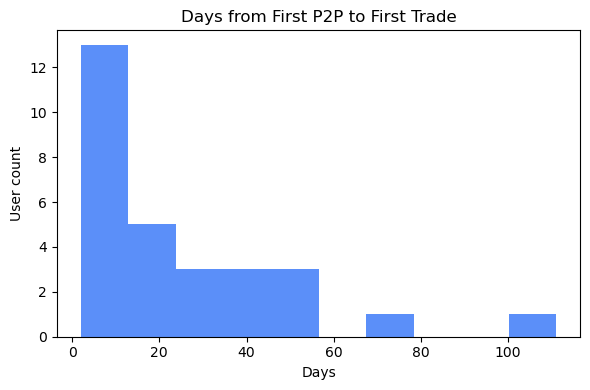

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

conversion = conversion_df  # jupysql helper
conversion = pd.DataFrame(conversion)

# Histogram of time-to-trade for users who converted
fig, ax = plt.subplots(figsize=(6, 4))
conversion.loc[conversion["traded_after_p2p"], "days_to_trade"].plot(
    kind="hist", bins=10, ax=ax, color="#5b8ff9"
)
ax.set_title("Days from First P2P to First Trade")
ax.set_xlabel("Days")
ax.set_ylabel("User count")
fig.tight_layout()

#### mart_conversion_summary_by_region

conversion group by region


In [85]:
%%sql
DROP TABLE IF EXISTS mart_conversion_summary_by_region;

CREATE TABLE mart_conversion_summary_by_region AS
WITH total_per_region AS (
    SELECT region, COUNT(*) AS total_users
    FROM dim_users
    GROUP BY region
)
SELECT
    t.region,
    SUM(CASE WHEN m.has_p2p THEN 1 ELSE 0 END) AS users_with_p2p,
    SUM(CASE WHEN m.has_trade THEN 1 ELSE 0 END) AS users_with_trade,
    SUM(CASE WHEN m.traded_after_p2p THEN 1 ELSE 0 END) AS users_traded_after_p2p,
    ROUND(AVG(m.days_to_trade), 2) AS avg_days_to_trade,
    ROUND(100.0 * SUM(CASE WHEN m.has_p2p THEN 1 ELSE 0 END) / t.total_users, 2) AS pct_users_with_p2p,
    ROUND(100.0 * SUM(CASE WHEN m.has_trade THEN 1 ELSE 0 END) / t.total_users, 2) AS pct_users_with_trade,
    ROUND(100.0 * SUM(CASE WHEN m.traded_after_p2p THEN 1 ELSE 0 END) / t.total_users, 2) AS pct_users_traded_after_p2p
FROM mart_user_conversion m
JOIN total_per_region t ON m.region = t.region
GROUP BY t.region, t.total_users
ORDER BY t.region;
select * from mart_conversion_summary_by_region;

,region,users_with_p2p,users_with_trade,users_traded_after_p2p,avg_days_to_trade,pct_users_with_p2p,pct_users_with_trade,pct_users_traded_after_p2p
0,Bandung,5.0,5.0,3.0,14.33,100.0,100.0,60.00
1,Denpasar,5.0,5.0,1.0,5.00,100.0,100.0,20.00
2,Jakarta,4.0,4.0,4.0,8.50,100.0,100.0,100.00
3,Makassar,7.0,7.0,5.0,39.00,100.0,100.0,71.43
4,Medan,10.0,10.0,6.0,12.50,100.0,100.0,60.00
5,Semarang,6.0,6.0,2.0,51.00,100.0,100.0,33.33
6,Surabaya,6.0,6.0,4.0,17.50,100.0,100.0,66.67
7,Yogyakarta,7.0,7.0,4.0,44.25,100.0,100.0,57.14


In [110]:
%%sql mart_conversion_summary_by_region <<
SELECT * FROM mart_conversion_summary_by_region;

In [115]:
mart_conversion_summary_by_region.to_clipboard()
mart_conversion_summary_by_region

,region,users_with_p2p,users_with_trade,users_traded_after_p2p,avg_days_to_trade,pct_users_with_p2p,pct_users_with_trade,pct_users_traded_after_p2p
0,Bandung,5.0,5.0,3.0,14.33,100.0,100.0,60.00
1,Denpasar,5.0,5.0,1.0,5.00,100.0,100.0,20.00
2,Jakarta,4.0,4.0,4.0,8.50,100.0,100.0,100.00
3,Makassar,7.0,7.0,5.0,39.00,100.0,100.0,71.43
4,Medan,10.0,10.0,6.0,12.50,100.0,100.0,60.00
5,Semarang,6.0,6.0,2.0,51.00,100.0,100.0,33.33
6,Surabaya,6.0,6.0,4.0,17.50,100.0,100.0,66.67
7,Yogyakarta,7.0,7.0,4.0,44.25,100.0,100.0,57.14


In [114]:
%%sql
SELECT
    region,
    count(*) AS user_count,
from dim_users
GROUP BY region
order by user_count desc;

,region,user_count
0,Medan,10
1,Makassar,7
2,Yogyakarta,7
3,Surabaya,6
4,Semarang,6
5,Denpasar,5
6,Bandung,5
7,Jakarta,4


In [87]:
%%sql
SELECT * FROM mart_user_conversion ORDER BY days_to_trade NULLS LAST LIMIT 10;

,user_id,region,first_transfer_date,first_trade_date,has_p2p,has_trade,days_to_trade,traded_after_p2p
0,U003,Medan,2024-01-12 02:02:13,2024-01-14 22:50:23,True,True,2,True
1,U037,Makassar,2024-01-04 14:40:05,2024-01-06 00:16:47,True,True,2,True
2,U050,Jakarta,2024-01-09 20:11:03,2024-01-12 15:54:16,True,True,3,True
3,U032,Makassar,2024-01-06 16:29:03,2024-01-10 20:58:49,True,True,4,True
4,U021,Medan,2024-01-04 23:14:03,2024-01-08 05:04:14,True,True,4,True
5,U046,Denpasar,2024-01-15 01:44:31,2024-01-20 01:58:57,True,True,5,True
6,U039,Jakarta,2024-01-03 15:22:52,2024-01-11 06:18:18,True,True,8,True
7,U024,Surabaya,2024-01-06 14:43:21,2024-01-14 23:02:42,True,True,8,True
8,U025,Jakarta,2024-01-01 17:40:13,2024-01-09 17:48:26,True,True,8,True
9,U047,Medan,2024-01-05 17:20:55,2024-01-16 07:05:38,True,True,11,True


#### mart_conversion_summary_by_token


In [88]:
%%sql
DROP TABLE IF EXISTS mart_conversion_summary_by_token;

CREATE TABLE mart_conversion_summary_by_token AS
WITH first_trade_token AS (
    SELECT user_id, token_id
    FROM (
        SELECT
            user_id,
            token_id,
            ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY trade_date) AS rn
        FROM fact_trades
    )
    WHERE rn = 1
),
user_token_category AS (
    SELECT
        u.user_id,
        COALESCE(tk.category, 'No Trade Yet') AS token_category
    FROM dim_users u
    LEFT JOIN first_trade_token ft USING (user_id)
    LEFT JOIN dim_tokens tk USING (token_id)
),
population AS (
    SELECT token_category, COUNT(*) AS total_users
    FROM user_token_category
    GROUP BY 1
)
SELECT
    utc.token_category,
    COUNT(*) FILTER (WHERE muc.has_p2p) AS users_with_p2p,
    COUNT(*) FILTER (WHERE muc.has_trade) AS users_with_trade,
    COUNT(*) FILTER (WHERE muc.traded_after_p2p) AS users_traded_after_p2p,
    AVG(muc.days_to_trade) FILTER (WHERE muc.traded_after_p2p) AS avg_days_to_trade,
    MEDIAN(muc.days_to_trade) FILTER (WHERE muc.traded_after_p2p) AS median_days_to_trade,
    CASE WHEN COUNT(*) FILTER (WHERE muc.has_p2p) > 0
         THEN CAST(COUNT(*) FILTER (WHERE muc.traded_after_p2p) AS DOUBLE)
              / COUNT(*) FILTER (WHERE muc.has_p2p)
    END AS conversion_rate,
    100.0 * COUNT(*) FILTER (WHERE muc.traded_after_p2p) / population.total_users
        AS pct_user_base_converted
FROM mart_user_conversion muc
JOIN user_token_category utc USING (user_id)
JOIN population ON utc.token_category = population.token_category
GROUP BY utc.token_category, population.total_users
ORDER BY conversion_rate DESC NULLS LAST;

SELECT * FROM mart_conversion_summary_by_token;

,token_category,users_with_p2p,users_with_trade,users_traded_after_p2p,avg_days_to_trade,median_days_to_trade,conversion_rate,pct_user_base_converted
0,Layer-1,28,28,18,27.611111,14.5,0.642857,64.285714
1,Meme Coin,22,22,11,18.545455,15.0,0.500000,50.000000


### Region and token category performance


### mart_region_category

Region and category performance


In [89]:
%%sql
DROP TABLE IF EXISTS mart_region_category;
CREATE TABLE mart_region_category AS
SELECT
    u.region,
    tk.category,
    DATE_TRUNC('month', t.trade_date) AS trade_month,
    SUM(t.trade_value_usd) AS trade_value_usd,
    COUNT(DISTINCT t.user_id) AS active_traders
FROM fact_trades t
LEFT JOIN dim_users u USING (user_id)
LEFT JOIN dim_tokens tk USING (token_id)
GROUP BY 1,2,3;
select * from mart_region_category;

,region,category,trade_month,trade_value_usd,active_traders
0,Medan,Layer-1,2024-02-01,2.755331e+04,3
1,Medan,Layer-1,2024-01-01,1.526822e+07,7
2,Semarang,Layer-1,2024-04-01,5.095122e+06,3
3,Surabaya,Layer-1,2024-02-01,6.950035e+07,4
4,Bandung,Meme Coin,2024-04-01,5.206618e+01,2
...,...,...,...,...,...
83,Yogyakarta,Meme Coin,2024-01-01,8.922839e+05,3
84,Jakarta,Layer-1,2024-05-01,3.417778e+06,3
85,Surabaya,Meme Coin,2024-02-01,4.670032e+05,1
86,Bandung,Meme Coin,2024-05-01,9.680862e+05,1


In [90]:
%%sql
SELECT * FROM mart_region_category ORDER BY trade_month, region LIMIT 10;

,region,category,trade_month,trade_value_usd,active_traders
0,Bandung,Meme Coin,2024-01-01,3.128449e+02,4
1,Bandung,Layer-1,2024-01-01,1.132926e+06,4
2,Denpasar,Layer-1,2024-01-01,1.101171e+07,4
3,Denpasar,Meme Coin,2024-01-01,2.895190e+05,2
4,Jakarta,Meme Coin,2024-01-01,9.441313e+01,1
5,Jakarta,Layer-1,2024-01-01,2.267895e+06,4
6,Makassar,Layer-1,2024-01-01,4.384597e+06,4
7,Makassar,Meme Coin,2024-01-01,3.329901e+05,3
8,Medan,Layer-1,2024-01-01,1.526822e+07,7
9,Medan,Meme Coin,2024-01-01,5.861470e+06,7


#### region retention


In [ ]:
%%sql    SELECT DISTINCT
        u.region,
        DATE_TRUNC('month', t.trade_date) AS trade_month,
        t.user_id
    FROM fact_trades t
    JOIN dim_users u USING (user_id)

In [91]:
%%sql
DROP TABLE IF EXISTS mart_region_retention;
CREATE TABLE mart_region_retention AS
WITH monthly AS (
    SELECT DISTINCT
        u.region,
        DATE_TRUNC('month', t.trade_date) AS trade_month,
        t.user_id
    FROM fact_trades t
    JOIN dim_users u USING (user_id)
),
pairs AS (
    SELECT
        m1.region,
        m1.trade_month AS from_month,
        m1.trade_month + INTERVAL '1' MONTH AS to_month,
        COUNT(DISTINCT m1.user_id) AS users_from,
        COUNT(DISTINCT m2.user_id) AS users_retained
    FROM monthly m1
    LEFT JOIN monthly m2
        ON m1.region = m2.region
        AND m1.user_id = m2.user_id
        AND m2.trade_month = m1.trade_month + INTERVAL '1' MONTH
    GROUP BY 1,2,3
)
SELECT
    region,
    from_month,
    to_month,
    users_from,
    users_retained,
    CASE WHEN users_from > 0
         THEN CAST(users_retained AS DOUBLE) / users_from
    END AS retention_rate
FROM pairs
WHERE users_from > 0
ORDER BY region, from_month;
select * from mart_region_retention;

,region,from_month,to_month,users_from,users_retained,retention_rate
0,Bandung,2024-01-01,2024-02-01,5,3,0.600000
1,Bandung,2024-02-01,2024-03-01,3,2,0.666667
2,Bandung,2024-03-01,2024-04-01,4,4,1.000000
3,Bandung,2024-04-01,2024-05-01,5,3,0.600000
4,Bandung,2024-05-01,2024-06-01,3,1,0.333333
5,Bandung,2024-06-01,2024-07-01,1,0,0.000000
6,Denpasar,2024-01-01,2024-02-01,5,5,1.000000
7,Denpasar,2024-02-01,2024-03-01,5,2,0.400000
8,Denpasar,2024-03-01,2024-04-01,2,1,0.500000
9,Denpasar,2024-04-01,2024-05-01,2,0,0.000000


In [119]:
%%sql
SELECT
    region,
    AVG(retention_rate) AS avg_retention_rate,
    MAX(CASE WHEN to_month = DATE_TRUNC('month', DATE '2024-06-01')
             THEN retention_rate END) AS last_observed_rate
FROM mart_region_retention
GROUP BY region
ORDER BY avg_retention_rate DESC;

,region,avg_retention_rate,last_observed_rate
0,Makassar,0.544444,0.666667
1,Bandung,0.533333,0.333333
2,Yogyakarta,0.522222,0.333333
3,Jakarta,0.513889,0.333333
4,Surabaya,0.488889,0.333333
5,Denpasar,0.400000,0.500000
6,Medan,0.379630,0.333333
7,Semarang,0.291667,0.000000


In [116]:
%%sql mart_region_retention <<
SELECT * FROM mart_region_retention;

In [117]:
mart_region_retention.to_clipboard()
mart_region_retention

,region,from_month,to_month,users_from,users_retained,retention_rate
0,Bandung,2024-01-01,2024-02-01,5,3,0.600000
1,Bandung,2024-02-01,2024-03-01,3,2,0.666667
2,Bandung,2024-03-01,2024-04-01,4,4,1.000000
3,Bandung,2024-04-01,2024-05-01,5,3,0.600000
4,Bandung,2024-05-01,2024-06-01,3,1,0.333333
5,Bandung,2024-06-01,2024-07-01,1,0,0.000000
6,Denpasar,2024-01-01,2024-02-01,5,5,1.000000
7,Denpasar,2024-02-01,2024-03-01,5,2,0.400000
8,Denpasar,2024-03-01,2024-04-01,2,1,0.500000
9,Denpasar,2024-04-01,2024-05-01,2,0,0.000000


#### Category Retention


In [92]:
%%sql
DROP TABLE IF EXISTS mart_category_retention;
CREATE TABLE mart_category_retention AS
WITH user_months AS (
    SELECT DISTINCT
        tk.category,
        t.user_id,
        DATE_TRUNC('month', t.trade_date) AS trade_month
    FROM fact_trades t
    JOIN dim_tokens tk USING (token_id)
),
span AS (
    SELECT
        category,
        user_id,
        COUNT(DISTINCT trade_month) AS active_months
    FROM user_months
    GROUP BY 1,2
)
SELECT
    category,
    COUNT(*) AS traders,
    AVG(CASE WHEN active_months > 1 THEN 1 ELSE 0 END) AS repeat_share
FROM span
GROUP BY 1;

,Count
0,2


In [93]:
%%sql
SELECT * FROM mart_category_retention;

,category,traders,repeat_share
0,Meme Coin,42,0.714286
1,Layer-1,49,0.877551


## Data quality checks


In [94]:
%%sql
DROP TABLE IF EXISTS dq_trade_duplicates;
CREATE TABLE dq_trade_duplicates AS
SELECT
    trade_id,
    COUNT(*) AS record_count,
    MIN(trade_created_time) AS first_trade_created_time,
    max(trade_created_time) AS last_trade_created_time,
    first_trade_created_time = last_trade_created_time AS is_exact_duplicate
FROM read_csv_auto('../../data/raw_trades.csv')
GROUP BY 1
HAVING COUNT(*) > 1;

DROP TABLE IF EXISTS dq_trade_outliers;
CREATE TABLE dq_trade_outliers AS
WITH limits AS (
    SELECT quantile_cont(trade_value_usd, 0.99) AS p99
    FROM fact_trades
)
SELECT
    f.*,
    limits.p99 AS threshold_99
FROM fact_trades f, limits
WHERE f.trade_value_usd > limits.p99;

DROP TABLE IF EXISTS dq_transfer_outliers;
CREATE TABLE dq_transfer_outliers AS
WITH limits AS (
    SELECT quantile_cont(amount, 0.99) AS p99
    FROM fact_transfers
)
SELECT
    ft.*,
    limits.p99 AS threshold_99
FROM fact_transfers ft, limits
WHERE ft.amount > limits.p99;

,Count
0,2


In [95]:
%%sql
SELECT * FROM dq_trade_duplicates;

,trade_id,record_count,first_trade_created_time,last_trade_created_time,is_exact_duplicate
0,TR0182,2,2024-03-09 15:01:15,2024-03-09 15:01:15,True
1,TR0072,2,2024-01-06 01:42:53,2024-01-06 01:42:53,True
2,TR0239,2,2024-04-17 00:19:08,2024-04-17 00:19:08,True


In [96]:
%%sql
SELECT * FROM dq_trade_outliers;

,trade_id,user_id,token_id,side,price_usd,quantity,trade_value_usd,trade_date,threshold_99
0,TR0226,U032,XRP,BUY,0.674144,210426879.9,1.418581e+08,2024-04-23 17:12:24,1.313072e+08
1,TR0300,U032,XRP,SELL,0.697087,314258287.1,2.190653e+08,2024-06-21 18:34:54,1.313072e+08
2,TR0201,U029,ADA,SELL,0.576034,461589381.6,2.658911e+08,2024-04-23 17:46:30,1.313072e+08


In [97]:
%%sql
SELECT * FROM dq_transfer_outliers;

,transfer_id,sender_id,receiver_id,token_id,amount,transfer_date,threshold_99
0,P2P0039,U037,U045,USDT,2590891.776,2024-01-09 06:51:01,738833.865762
1,P2P0091,U012,U006,USDT,1988362.552,2024-03-03 19:24:44,738833.865762


In [98]:
%%sql
SELECT
    status,
    COUNT(*) AS trade_count,
    printf('%.2f%%', 100.0 * COUNT(*) / SUM(COUNT(*)) OVER ()) AS trade_pct
FROM stg_trades
GROUP BY status
ORDER BY trade_count DESC;

,status,trade_count,trade_pct
0,FILLED,268,89.33%
1,FAILED,32,10.67%


In [99]:
%%sql
SELECT status, COUNT(*) AS transfer_count,
printf('%.2f%%', 100.0 * COUNT(*) / SUM(COUNT(*)) OVER ()) AS transfer_count
FROM stg_transfers
GROUP BY 1;

,status,transfer_count,transfer_count_1
0,SUCCESS,164,91.11%
1,FAILED,16,8.89%


## Export to parquet


In [100]:
%sql --close duckdb:///dev.db

In [101]:
import duckdb
from pathlib import Path

con = duckdb.connect("dev.db")

EXPORT_ROOT = Path("notebook/dev/exports")
EXPORT_ROOT.mkdir(parents=True, exist_ok=True)

tables = [
    # staging
    "stg_transfers",
    "stg_tokens",
    "stg_trades",
    "stg_users",
    # dimensions
    "dim_users",
    "dim_tokens",
    "dim_datetime",
    # facts
    "fact_trades",
    "fact_transfers",
    # marts
    "mart_token_concentration",
    "mart_trader_concentration",
    "mart_concentration_summary",
    "mart_monthly_trading",
    "mart_user_conversion",
    "mart_conversion_summary",
    "mart_conversion_summary_by_region",
    "mart_conversion_summary_by_token",
    "mart_region_category",
    "mart_region_retention",
    "mart_category_retention",
    # data quality
    "dq_trade_duplicates",
    "dq_trade_outliers",
    "dq_transfer_outliers",
]


def table_exists(name: str) -> bool:
    return (
        con.execute(
            "SELECT COUNT(*) FROM information_schema.tables WHERE table_name = ?",
            [name],
        ).fetchone()[0]
        == 1
    )


for table in tables:
    if not table_exists(table):
        print(f"⚠️  Skip {table}: table not found.")
        continue

    target = EXPORT_ROOT / f"{table}.parquet"
    con.execute(
        f"COPY (SELECT * FROM {table}) TO '{target.as_posix()}' (FORMAT PARQUET);"
    )
    print(f"✅ Exported {table} → {target}")

con.close()

✅ Exported stg_transfers → notebook/dev/exports/stg_transfers.parquet
✅ Exported stg_tokens → notebook/dev/exports/stg_tokens.parquet
✅ Exported stg_trades → notebook/dev/exports/stg_trades.parquet
✅ Exported stg_users → notebook/dev/exports/stg_users.parquet
✅ Exported dim_users → notebook/dev/exports/dim_users.parquet
✅ Exported dim_tokens → notebook/dev/exports/dim_tokens.parquet
✅ Exported dim_datetime → notebook/dev/exports/dim_datetime.parquet
✅ Exported fact_trades → notebook/dev/exports/fact_trades.parquet
✅ Exported fact_transfers → notebook/dev/exports/fact_transfers.parquet
✅ Exported mart_token_concentration → notebook/dev/exports/mart_token_concentration.parquet
✅ Exported mart_trader_concentration → notebook/dev/exports/mart_trader_concentration.parquet
✅ Exported mart_concentration_summary → notebook/dev/exports/mart_concentration_summary.parquet
✅ Exported mart_monthly_trading → notebook/dev/exports/mart_monthly_trading.parquet
✅ Exported mart_user_conversion → notebook

In [102]:
con.close()